In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

from scipy import stats
from scipy.spatial.distance import pdist, squareform, euclidean

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [4]:
with open(DATAFOLDER / "bazzino_data_for_frejus.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]

In [46]:
pcafile = RESULTSFOLDER / "transformed_data_photo.pickle"

with open(pcafile, 'rb') as f:
    pca = dill.load(f)

pc1 = pca[:,0]
pca_data = pca[:, :5]

In [47]:
pca_data.shape

(1960, 5)

In [48]:
# calculate centroids
cluster_0_centroid = pca_data[x_array.cluster_photo == 0].mean(axis=0)
cluster_1_centroid = pca_data[x_array.cluster_photo == 1].mean(axis=0)

# Step 2: Define the cluster separation vector
cluster_vector = cluster_1_centroid - cluster_0_centroid

# Step 3: Project each observation onto the cluster vector
# Normalize the cluster vector
cluster_vector_norm = cluster_vector / np.linalg.norm(cluster_vector)
# Compute projections
projections = np.dot(pca_data - cluster_0_centroid, cluster_vector_norm)

# Step 4: Normalize the projections to range between 0 and 1
min_projection = projections.min()
max_projection = projections.max()
normalized_projections = (projections - min_projection) / (max_projection - min_projection)

x_array = x_array.assign(clusterness_photo=normalized_projections)

In [49]:
x_array.columns

Index(['trial', 'id', 'condition', 'infusiontype', 'cluster_photo',
       'cluster_vel', 'auc_snips', 'auc_vel', 'clusterness_photo'],
      dtype='object')

In [51]:
from scipy.ndimage import gaussian_filter1d

for rat in rats:
    mask = x_array.id == rat
    clusterness = x_array.loc[mask, 'clusterness_photo'].values
    
    # Apply Gaussian smoothing
    smoothed = gaussian_filter1d(clusterness, sigma=2)  # Adjust sigma
    x_array.loc[mask, 'clusterness_photo_smoothed'] = smoothed

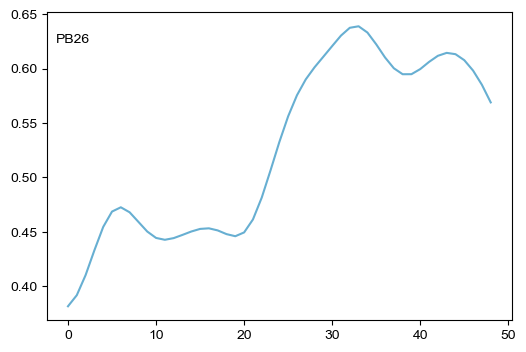

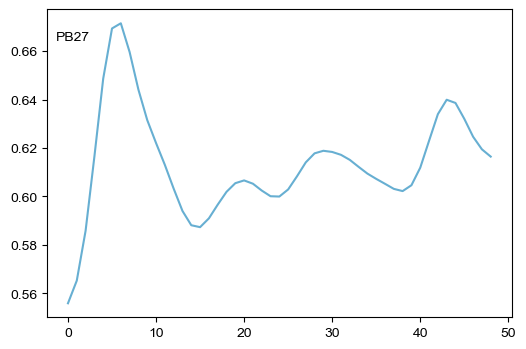

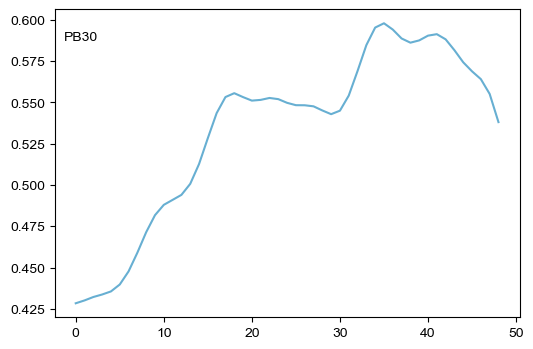

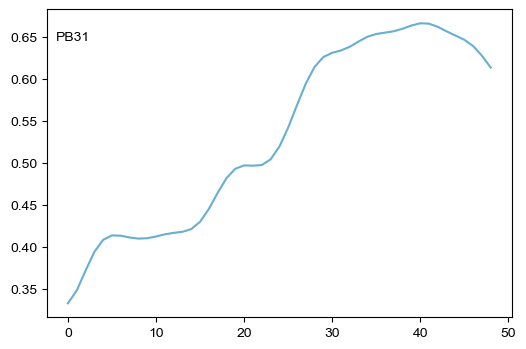

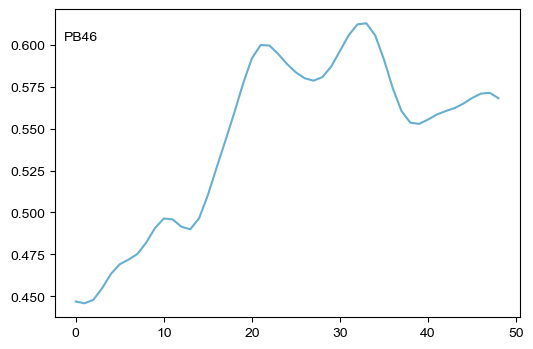

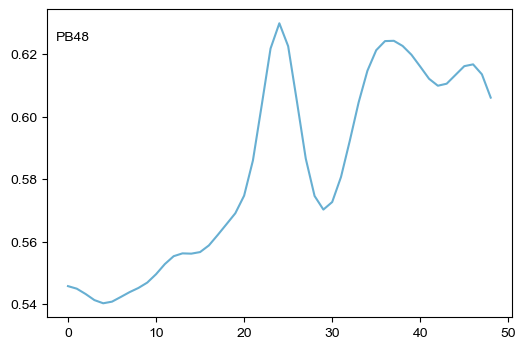

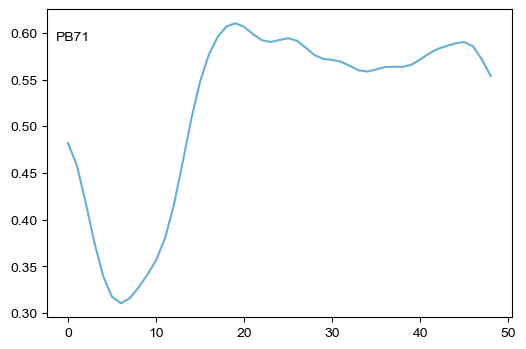

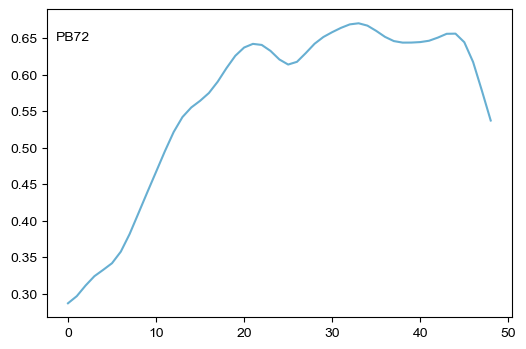

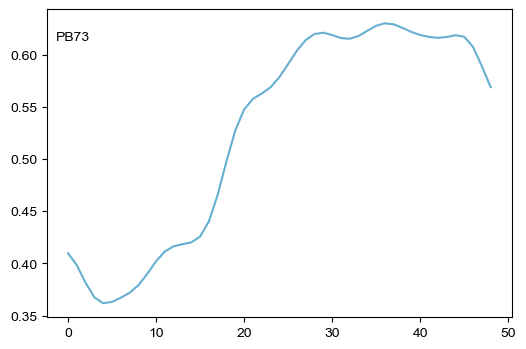

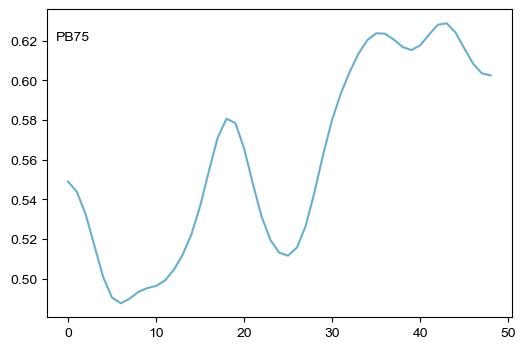

In [53]:
# just select 0.45 and deplete Na+ condition
x_array_red = x_array.query("infusiontype == '45NaCl' & condition == 'deplete'")
rats = x_array_red.id.unique()

for rat in rats:
    x_rat = x_array_red.query("id == @rat")
    snips_photo_rat = snips_photo[x_array.query("infusiontype == '45NaCl' & condition == 'deplete' & id == @rat").index]
    snips_vel_rat = snips_vel[x_array.query("infusiontype == '45NaCl' & condition == 'deplete' & id == @rat").index]
    # pc1_rat = pc1[x_array.query("infusiontype == '45NaCl' & condition == 'deplete' & id == @rat").index]

    f, ax = plt.subplots(figsize=(6,4), sharex=True)
    ax.plot(x_rat.trial, x_rat.clusterness_photo_smoothed, color=colors[0], label='Photo')
    ax.text(0.02, 0.9, rat, transform=ax.transAxes)



Fitted parameters: [ 0.75292637 -1.80017537  0.03518061]


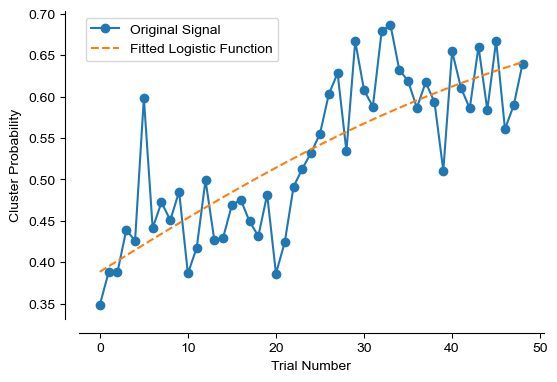

In [64]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define logistic function
def logistic(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

def hill(x, L, K, n):
    return L * (x**n) / (K**n + x**n)

# Example signal with smooth transitions
x = np.linspace(0, 10, 100)
signal = 1 / (1 + np.exp(-(x - 5)))  # Logistic function

signal = x_array.query("condition == 'deplete' & infusiontype == '45NaCl' & id == 'PB26'").clusterness_photo
x = np.arange(len(signal))

# Fit logistic function to the signal
popt, _ = curve_fit(logistic, x, signal, p0=[0.6, 20, 1])  # Initial guesses for L, x0, k
# popt, _ = curve_fit(hill, x, signal, p0=[0.6, 10, 1])  # Initial guesses for L, x0, k

# Plot the signal and the fitted function
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, signal, label="Original Signal", marker="o")
ax.plot(x, logistic(x, *popt), label="Fitted Logistic Function", linestyle="--")
ax.legend()
ax.set_xlabel("Trial Number")
ax.set_ylabel("Cluster Probability")
# ax.set_ylim([1,-0.1])
# ax.set_yticks([0, 0.5, 1], labels=["1", "0.5", "0"])

sns.despine(ax=ax, offset=10)

print("Fitted parameters:", popt)

id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
[-1.95833480e-18  4.99999999e+00 -9.99999984e-01            -inf]
[-1.95833480e-18  4.99999999e+00 -9.99999984e-01            -inf]
[-1.9583

C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\3138511051.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\j

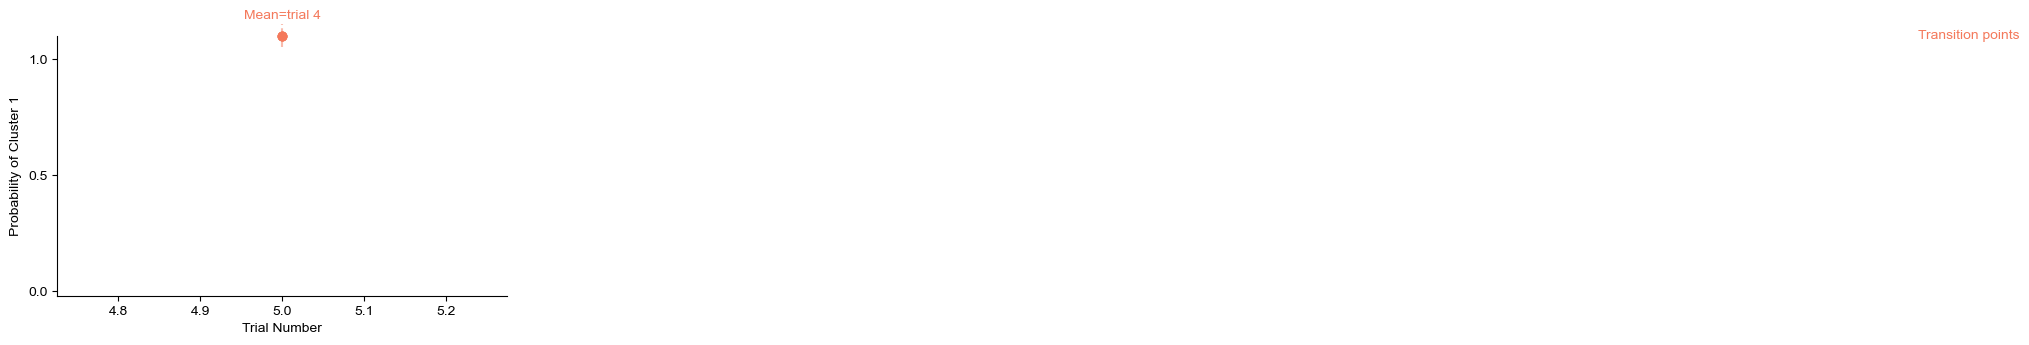

In [30]:
all_logistic_fits = []

df2_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

for rat in df2_dep_45.id.unique():
    signal = x_array.query("id == @rat & condition == 'deplete' & infusiontype == '45NaCl'").clusterness_photo
    y = np.logical_not(signal).astype(int) # inverted signal
    
    x = np.arange(len(signal))

    try:
        popt, _ = curve_fit(logistic, x, y, p0=[1, 5, -1])  # Initial guesses for L, x0, k

        print(f"id: {id}, params: {popt}")

        y_fit = logistic(x, *popt)
        ss_res = np.sum((y - y_fit) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

    except RuntimeError as e:
        print(f"Could not fit logistic for id {id}: {e}")
        r_squared = np.nan

    all_logistic_fits.append(np.concatenate([popt, [r_squared]]))

x = np.arange(len(signal))
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
     
f, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'left': 0.2, 'right': 0.95, 'top': 0.85, 'bottom': 0.2})

for fit in all_logistic_fits:
    print(fit)
    if fit[0] < 0.5:
        continue
    ax.plot(x, logistic(x, *fit[:-1]), label="Fitted Logistic Function", linestyle="--", color=colors[2])
    
sns.despine(ax=ax)
ax.set_xlabel("Trial Number")
ax.set_ylabel("Probability of Cluster 1")

x0 = np.array(all_logistic_fits)[:,1]

ax.plot(x0, [1.1]*len(x0), marker="o", linestyle="None", color=colors[2], alpha=0.5, clip_on=False)
ax.text(np.max(x0)+2, 1.1, "Transition points", ha="left", va="center", fontsize=10, color=colors[2])

ax.plot([np.mean(x0), np.mean(x0)], [1.05, 1.15], color=colors[2], linestyle="--", alpha=0.5, clip_on=False)
ax.text(np.mean(x0), 1.16, f"Mean=trial {int(np.mean(x0))}", ha="center", va="bottom", fontsize=10, color=colors[2])

ax.set_yticks([0, 0.5, 1])
ax.set_ylim([-0.02, 1.1])

if savefigs:
    f.savefig(FIGSFOLDER / "logistic_fits_45NaCl.pdf", dpi=600, transparent=True)


In [ ]:
from scipy.spatial.distance import pdist, squareform, euclidean

for rat in rats:
    pc_rat = pca[x_array.query("id == 'PB26'").index, :5]  # First 3 PCs
    
    # Pairwise distances within this rat's data
    distances_rat = pdist(pc_rat, metric='euclidean')
    distance_matrix_rat = squareform(distances_rat)

    # f, ax = plt.subplots(figsize=(6,4))
    print(distances_rat.shape)

(4753,)
(4753,)
(4753,)
(4753,)
(4753,)
(4753,)
(4753,)
(4753,)
(4753,)
(4753,)


In [ ]:
x_array.cluster_photo

0       0
1       0
2       1
3       0
4       0
       ..
1955    1
1956    1
1957    1
1958    1
1959    1
Name: cluster_photo, Length: 1960, dtype: int64

PB26 (49,)
PB27 (49,)
PB30 (49,)
PB31 (49,)
PB46 (49,)
PB48 (49,)
PB71 (49,)
PB72 (49,)
PB73 (49,)
PB75 (49,)


C:\Users\jmc010\AppData\Local\Temp\ipykernel_19260\649613075.py:3: RuntimeWarning: Mean of empty slice.
  cluster_0_centroid = pca_data[labels == 0].mean(axis=0)
c:\Users\jmc010\.local\share\mamba\envs\default\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


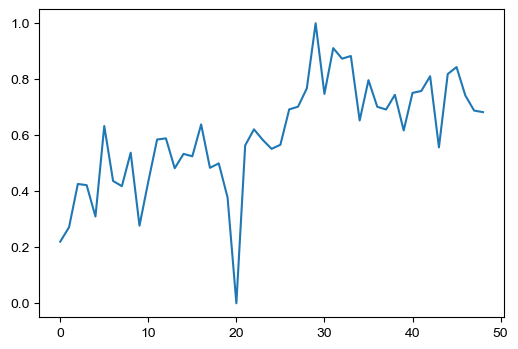

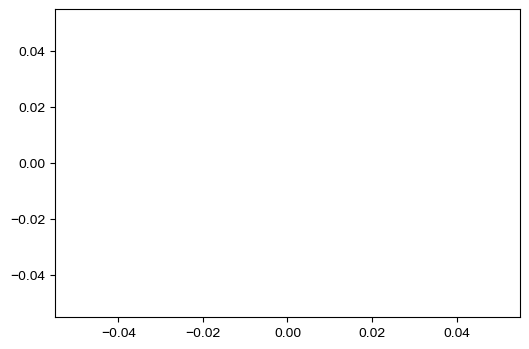

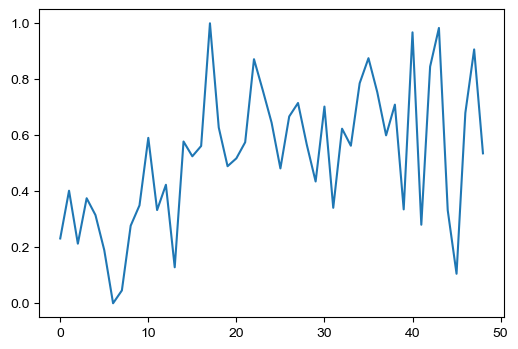

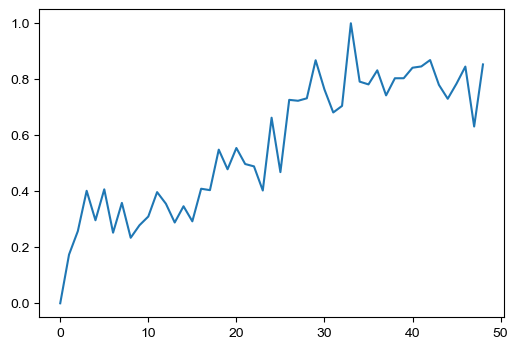

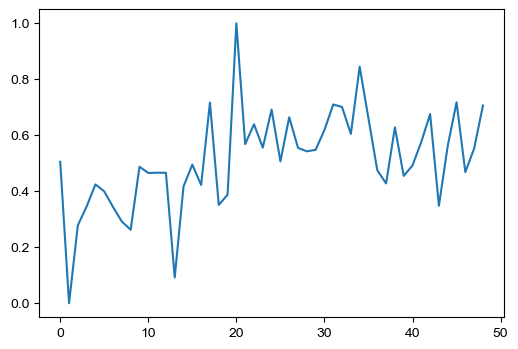

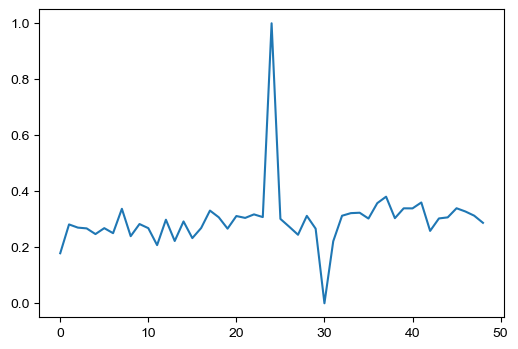

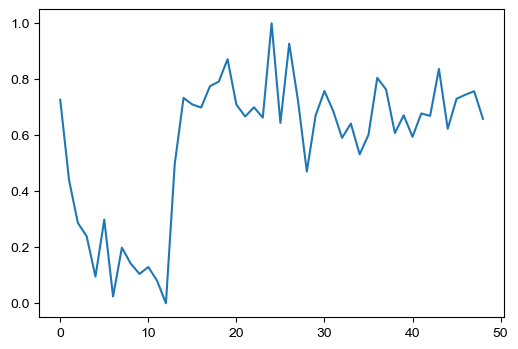

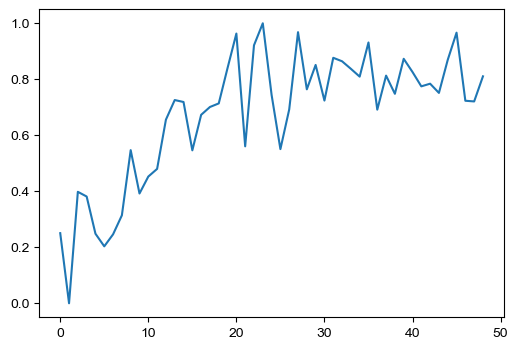

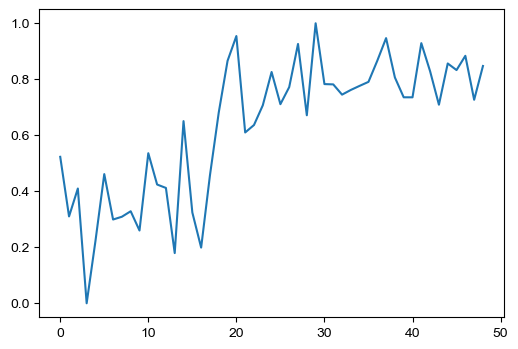

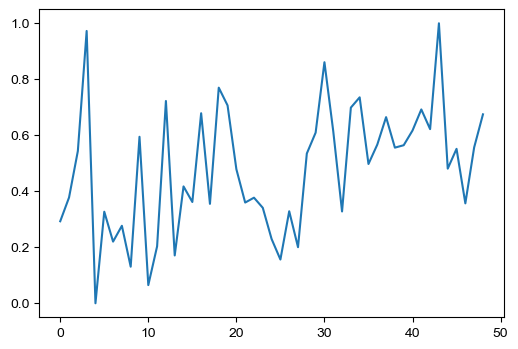

In [57]:
def get_normd_proj(pca_data, labels):
    # calculate centroids
    cluster_0_centroid = pca_data[labels == 0].mean(axis=0)
    cluster_1_centroid = pca_data[labels == 1].mean(axis=0)

    # Step 2: Define the cluster separation vector
    cluster_vector = cluster_1_centroid - cluster_0_centroid

    # Step 3: Project each observation onto the cluster vector
    # Normalize the cluster vector
    cluster_vector_norm = cluster_vector / np.linalg.norm(cluster_vector)
    # Compute projections
    projections = np.dot(pca_data - cluster_0_centroid, cluster_vector_norm)

    # Step 4: Normalize the projections to range between 0 and 1
    min_projection = projections.min()
    max_projection = projections.max()
    normalized_projections = (projections - min_projection) / (max_projection - min_projection)

    return normalized_projections

x_array_red = x_array.query("infusiontype == '45NaCl' & condition == 'deplete'")
rats = x_array_red.id.unique()
for rat in rats:
    pc_rat = pca[x_array_red.query("id == @rat").index, :3]  # First 3 PCs
    labels_rat = x_array_red.query("id == @rat").cluster_photo.values

    normd_proj_rat = get_normd_proj(pc_rat, labels_rat)
    print(rat, normd_proj_rat.shape)

    f, ax = plt.subplots(figsize=(6,4))
    ax.plot(normd_proj_rat)

Cross-correlation values: [  0.62604233   0.61886898   1.04749996   0.30025128  -3.70222452
  -4.40299829  -5.04889982  -5.60096819  -5.80448651  -6.92213073
  -8.67596538 -13.7262199  -13.49825386 -16.14813305 -16.88164479
 -17.90106923 -18.60034327 -12.64659076 -12.32986119 -10.39238666
  -7.19618111  -9.02512681  -9.43933312  -9.24946389  -8.78655697
 -10.84362408 -11.26387237 -11.61103206 -12.43030119 -10.87374472
  -8.19508216  -6.4423323   -5.89849437  -6.44084466  -7.56443008
  -3.14647969  -0.66936115  -1.94306898  -0.23738067   3.04737301
   1.75220835   4.45367225   7.21046102   7.53935882  11.81163691
  14.80159518  18.01727931  19.9897087   20.60070428  18.96891675
  18.39755596  16.54544598  16.06781777  21.18363299  20.86829189
  20.22246318  20.9724984   20.27702103  20.17438131  23.4235972
  26.01309894  26.13439248  28.79860454  28.87280956  30.54180336
  30.16159785  25.7647868   24.12218725  22.17659249  21.22937314
  21.07452015  22.53286504  22.0187486   20.9492388

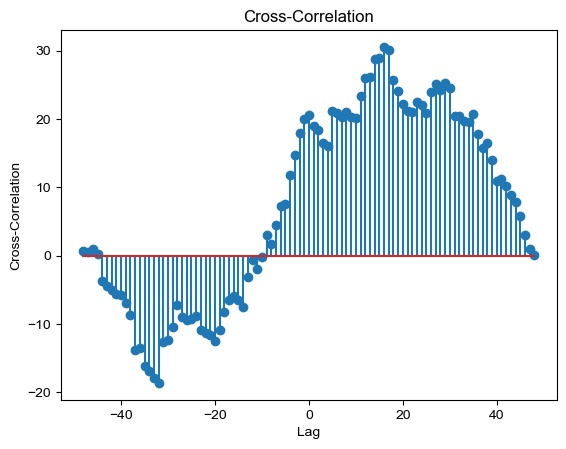

In [ ]:
x_rat = x_array_red.query("id == @rat")


x = x_rat.clusterness_photo.values
y = x_rat.auc_vel.values



import numpy as np
import matplotlib.pyplot as plt
# Example signals
#x = np.array([1, 2, 3, 4, 5])
#y = np.array([0, 1, 2, 3, 4])
# Compute cross-correlation
cross_corr = np.correlate(x, y, mode='full')
# Lags
lags = np.arange(-len(x) + 1, len(x))
# Find the lag with the maximum correlation
max_corr_index = np.argmax(cross_corr)
best_lag = lags[max_corr_index]
print("Cross-correlation values:", cross_corr)
print("Best lag:", best_lag)
# Plot the cross-correlation
plt.stem(lags, cross_corr)
plt.title("Cross-Correlation")
plt.xlabel("Lag")
plt.ylabel("Cross-Correlation")
plt.show()

In [70]:
all_lags = []

for rat in rats:
    x_rat = x_array_red.query("id == @rat")

    x = x_rat.clusterness_photo.values
    y = x_rat.auc_vel.values

    cross_corr = np.correlate(x, y, mode='full')
    # Lags
    lags = np.arange(-len(x) + 1, len(x))
    # Find the lag with the maximum correlation
    max_corr_index = np.argmax(cross_corr)
    best_lag = lags[max_corr_index]

    all_lags.append(best_lag)

print("All best lags:", all_lags)

All best lags: [np.int64(-23), np.int64(-4), np.int64(-32), np.int64(-17), np.int64(-10), np.int64(-23), np.int64(-8), np.int64(-17), np.int64(-31), np.int64(-16)]


In [67]:
x_rat.columns

Index(['trial', 'id', 'condition', 'infusiontype', 'cluster_photo',
       'cluster_vel', 'auc_snips', 'auc_vel', 'clusterness_photo',
       'clusterness_photo_smoothed'],
      dtype='object')